In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats

#### Define CESM case and get the years of data that we'll average over

In [2]:
start_yr=248
num_years=60 #sim years since last parm change
endyr=start_yr + num_years +1
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
user = 'kristenk'

In [3]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/scratch/{user}/archive/{case}/ocn/hist/{case}.pop.h.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 248 !
doing simulation year 249 !
doing simulation year 250 !
doing simulation year 251 !
doing simulation year 252 !
doing simulation year 253 !
doing simulation year 254 !
doing simulation year 255 !
doing simulation year 256 !
doing simulation year 257 !
doing simulation year 258 !
doing simulation year 259 !
doing simulation year 260 !
doing simulation year 261 !
doing simulation year 262 !
doing simulation year 263 !
doing simulation year 264 !
doing simulation year 265 !
doing simulation year 266 !
doing simulation year 267 !
doing simulation year 268 !
doing simulation year 269 !
doing simulation year 270 !
doing simulation year 271 !
doing simulation year 272 !
doing simulation year 273 !
doing simulation year 274 !
doing simulation year 275 !
doing simulation year 276 !
doing simulation year 277 !
doing simulation year 278 !
doing simulation year 279 !
doing simulation year 280 !
doing simulation year 281 !
doing simulation year 282 !
doing simulation yea

In [ ]:
cesm_mon_ds=xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')

In [ ]:
variables = ['ALK_ALT_CO2','ALK','DIC_ALT_CO2','DIC','SALT','TEMP','PD'] 

In [ ]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keep_vars])

In [ ]:
cesm_ann_ds=cesm_mon_ds.mean(dim='time')

In [4]:
# outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/mean5thIAF/annual_means.nc'
# cesm_ann_ds=xr.open_dataset(outfile,decode_times=False,decode_coords=False)

In [6]:
# outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/mean5thIAF/annual_means2.nc'
# cesm_ann_ds2=xr.open_dataset(outfile,decode_times=False,decode_coords=False)

In [ ]:
cesm_ann_ds

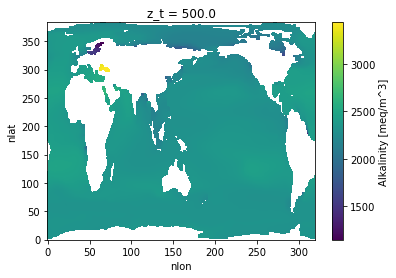

In [8]:
cesm_ann_ds.ALK.isel(z_t=0).plot()

### Define a few plotting functions

In [8]:
def canvas_map_contour_overlay(lon,lat,z,
                               contour_specs,
                               units,
                               fig,
                               gridspec,
                               row,col):
    #-- make masked
    z = np.ma.masked_invalid(z)
    
    #-- make canvas
    ax = fig.add_subplot(gridspec[row,col],projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_global()

    #-- make filled contours
    cf = ax.contourf(lon,lat,z,
                     transform=ccrs.PlateCarree(),
                     **contour_specs)
    #-- rasterize
    zorder = 0
    for contour_level in cf.collections:
        contour_level.set_zorder(zorder)
        contour_level.set_rasterized(True)

    #-- add contour lines
    cs = ax.contour(lon,lat,z,
                    colors='k',
                    levels = contour_specs['levels'],
                    linewidths = 0.5,
                    transform=ccrs.PlateCarree(),
                    zorder=len(cf.collections)+10)
    fmt = '%r'
    #-- add contour labels
    lb = plt.clabel(cs, fontsize=8,
                   inline = True,
                   fmt=fmt)

    #-- add land mask
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='face',
                                            facecolor='black'))

    #-- add colorbar
    i = 0
    while True:
        i += 1
        try:
            gridspec[i]
        except:
            break
    len_gs = i
    if len_gs == 1:
        shrink_factor = 0.75
    else:
        shrink_factor = 0.75

    cb = fig.colorbar(cf,ax = ax,
                      ticks = contour_specs['levels'],
                      orientation = 'vertical',
                      shrink = shrink_factor)
    cb.ax.set_title(units)
    cb.ax.tick_params(labelsize=9) 

    return {'ax':ax,'cf':cf,'cs':cs,'lb':lb,'cb':cb}

In [9]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

#### Define plotting coords with WOA on POP grid
#### (doesn't have the nans in the coords)

In [10]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = cesm_ann_ds.z_t

In [11]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

In [12]:
depths.values[55]

4375.3926

#### Plot by depth

In [14]:
diff_surf = cesm_ann_ds.ALK_ALT_CO2.isel(z_t=0) - cesm_ann_ds.ALK.isel(z_t=0)

In [15]:
diff_55m = cesm_ann_ds.ALK_ALT_CO2.isel(z_t=5) - cesm_ann_ds.ALK.isel(z_t=5)

In [16]:
diff_105m = cesm_ann_ds.ALK_ALT_CO2.isel(z_t=10) - cesm_ann_ds.ALK.isel(z_t=10)

In [17]:
diff_200m = cesm_ann_ds.ALK_ALT_CO2.isel(z_t=19) - cesm_ann_ds.ALK.isel(z_t=19)

In [18]:
diff_483m = cesm_ann_ds.ALK_ALT_CO2.isel(z_t=32) - cesm_ann_ds.ALK.isel(z_t=32)

In [19]:
diff_787m = cesm_ann_ds.ALK_ALT_CO2.isel(z_t=37) - cesm_ann_ds.ALK.isel(z_t=37)

In [20]:
diff_1400m = cesm_ann_ds.ALK_ALT_CO2.isel(z_t=42) - cesm_ann_ds.ALK.isel(z_t=42)

In [21]:
diff_1967m = cesm_ann_ds.ALK_ALT_CO2.isel(z_t=45) - cesm_ann_ds.ALK.isel(z_t=45)

In [22]:
diff_2889m = cesm_ann_ds.ALK_ALT_CO2.isel(z_t=49) - cesm_ann_ds.ALK.isel(z_t=49)

In [23]:
diff_4375m = cesm_ann_ds.ALK_ALT_CO2.isel(z_t=55) - cesm_ann_ds.ALK.isel(z_t=55)

In [13]:
# fig = plt.figure(figsize=(16,16))

# ######### Alk diff at surface layer
# ax = fig.add_subplot(4,2,1, projection=ccrs.Robinson(central_longitude=305.0))
# ax.set_title('a) Alk_nocalc - Alk at surface (5m)', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lons, lats, diff_surf, cmap='bwr',vmin=-70, vmax=70,transform=ccrs.PlateCarree())


# ######### Alk diff at 200 m
# ax = fig.add_subplot(4,2,2, projection=ccrs.Robinson(central_longitude=305.0))
# ax.set_title('b) Alk_nocalc - Alk 200m', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lons, lats, diff_200m, cmap='bwr',vmin=-70, vmax=70,transform=ccrs.PlateCarree())

# ######### Alk diff at 482 m
# ax = fig.add_subplot(4,2,3, projection=ccrs.Robinson(central_longitude=305.0))
# ax.set_title('c) Alk_nocalc - Alk 483m', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lons, lats, diff_483m, cmap='bwr',vmin=-40, vmax=40,transform=ccrs.PlateCarree())

# ######### Alk diff at 787 m
# ax = fig.add_subplot(4,2,4, projection=ccrs.Robinson(central_longitude=305.0))
# ax.set_title('d) Alk_nocalc - Alk 787m', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lons, lats, diff_787m, cmap='bwr',vmin=-40, vmax=40,transform=ccrs.PlateCarree())


# ######### Alk diff at 1400 m
# ax = fig.add_subplot(4,2,5, projection=ccrs.Robinson(central_longitude=305.0))
# ax.set_title('e) Alk_nocalc - Alk 1400m', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lons, lats, diff_1400m, cmap='bwr',vmin=-40, vmax=40,transform=ccrs.PlateCarree())

# ######### Alk diff at 1967 m
# ax = fig.add_subplot(4,2,6, projection=ccrs.Robinson(central_longitude=305.0))
# ax.set_title('f) Alk_nocalc - Alk 1967m', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lons, lats, diff_1967m, cmap='bwr',vmin=-40, vmax=40,transform=ccrs.PlateCarree())

# ######### Alk diff at 2889 m
# ax = fig.add_subplot(4,2,7, projection=ccrs.Robinson(central_longitude=305.0))
# ax.set_title('g) Alk_nocalc - Alk 2889m', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lons, lats, diff_2889m, cmap='bwr',vmin=-40, vmax=40,transform=ccrs.PlateCarree())

# ######### Alk diff at 4375 m
# ax = fig.add_subplot(4,2,8, projection=ccrs.Robinson(central_longitude=305.0))
# ax.set_title('g) Alk_nocalc - Alk 4375m', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lons, lats, diff_4375m, cmap='bwr',vmin=-40, vmax=40,transform=ccrs.PlateCarree())

# fig.subplots_adjust(right=0.8,hspace=0)
# cbar_ax = fig.add_axes([0.85, 0.16, 0.015, 0.7])
# cbar = fig.colorbar(pc, cax=cbar_ax,label='Difference in alkalinity (mmol/m3)',extend='both')

### Isopycnals

#### Define 3D interpolation function

In [14]:
def interp3d(coord_field,ds,new_levels,dim,**kwargs):
    '''kludged function for interpolation
    '''

    method = kwargs.pop('method','linear')
    if method == 'linear':
        from metpy.interpolate import interpolate_1d
        interp_func = interpolate_1d
    elif method == 'log':
        from metpy.interpolate import log_interpolate_1d
        interp_func = log_interpolate_1d

    newdim = new_levels.dims[0]

    dso = xr.Dataset()
    for v in ds.variables:

        if dim not in ds[v].dims:
            dso[v] = ds[v]
        else:

            dims_in = ds[v].dims
            if len(dims_in) == 1: continue

            interp_axis = dims_in.index(dim)
            dims_out = list(dims_in)
            dims_out[interp_axis] = newdim

            dso[v] = xr.DataArray(
                interp_func(new_levels.values,
                            coord_field.values,ds[v].values,axis=interp_axis),
                dims=dims_out,attrs=ds[v].attrs)
    dso[newdim] = new_levels
    return dso

#### Put data on sigma coords

In [15]:
na = np.newaxis
pressure = sw.eos80.pres(depths.values[:,na,na],ds_woa.TLAT.values[:,:])

In [16]:
pressure.shape

(60, 384, 320)

In [17]:
pDensity = sw.pden(cesm_ann_ds.SALT, cesm_ann_ds.TEMP, pressure)-1000.

In [18]:
cesm_ann_ds['pdens'] = xr.DataArray(pDensity,dims=('z_t','nlat','nlon'))

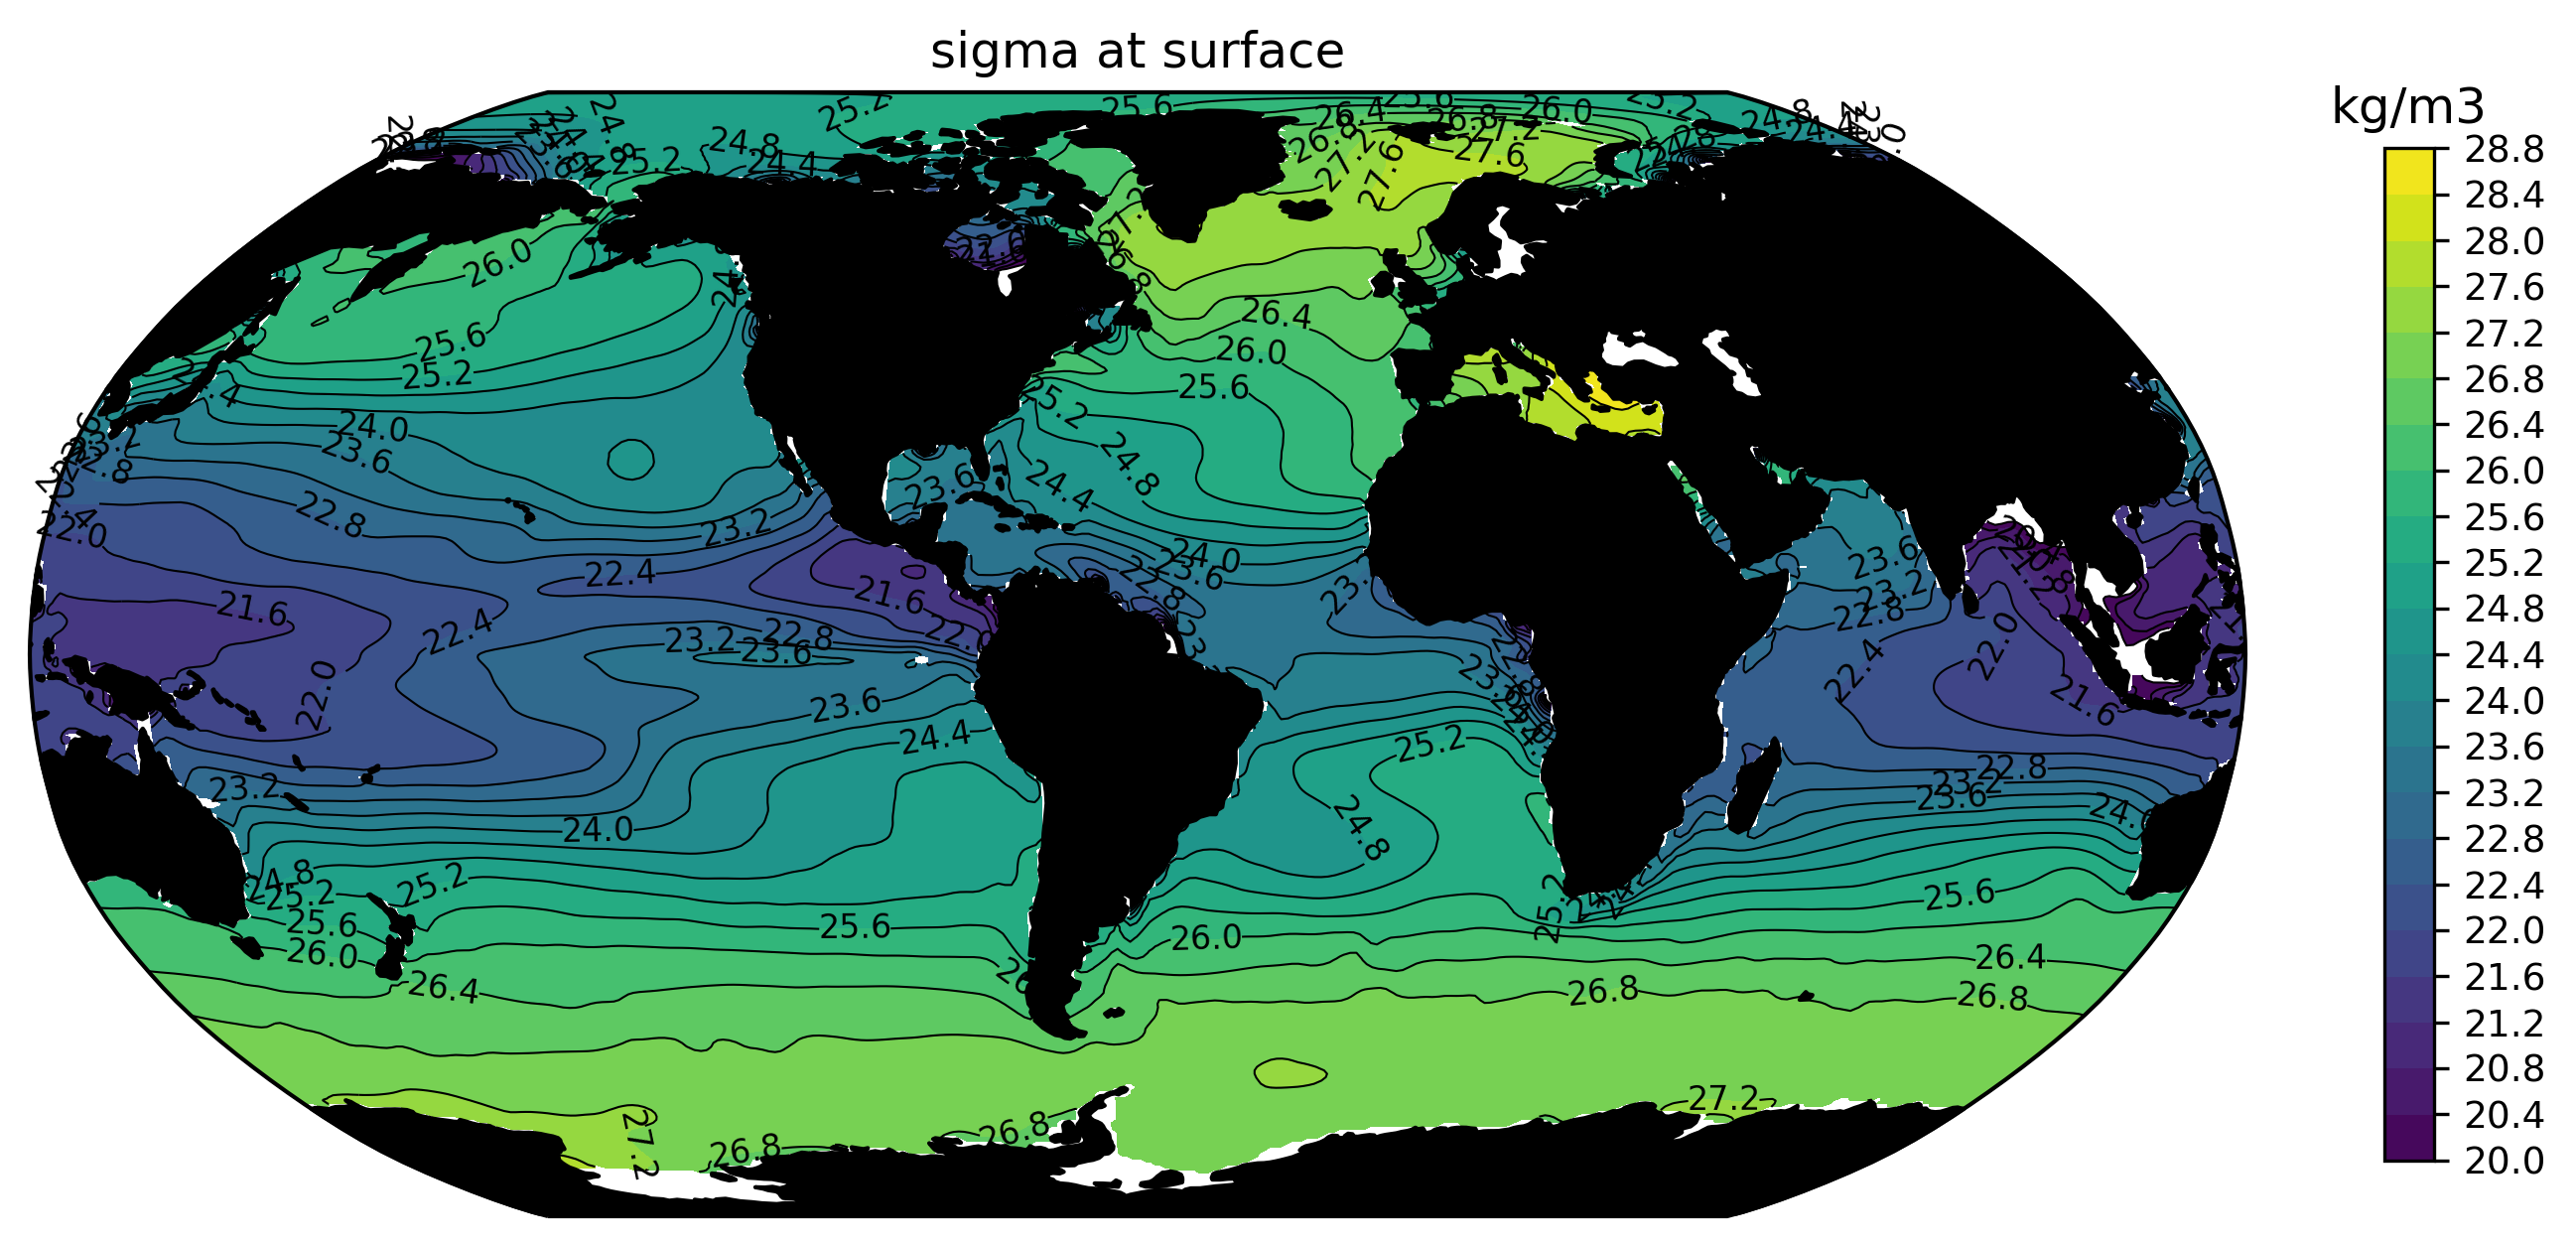

In [30]:
m={}
units = 'kg/m3'
plot_name = 'sigma at surface'
var='sigma'
field = cesm_ann_ds.pdens.isel(z_t=0)
lon,lat,field = adjust_pop_grid(lons,lats,field)

contour_specs = {'levels': np.around(np.arange(20., 29., 0.4),decimals=1)}
fig=plt.figure(figsize=(12, 6),dpi=300)
gs = gridspec.GridSpec(1,1)

m[var] = canvas_map_contour_overlay(lon,lat,field,
                                    contour_specs,
                                    units = units,
                                    fig=fig,
                                    gridspec=gs,
                                    row=0,col=0)
m[var]['ax'].set_title(plot_name);

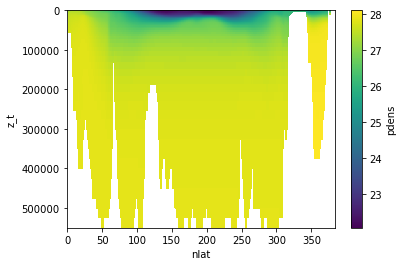

In [31]:
#zonal slice
sigma_Pacific = cesm_ann_ds.pdens.isel(nlon=200)
sigma_Pacific.plot(yincrease=False)

In [19]:
np.arange(21., 29., 0.2)

array([21. , 21.2, 21.4, 21.6, 21.8, 22. , 22.2, 22.4, 22.6, 22.8, 23. ,
       23.2, 23.4, 23.6, 23.8, 24. , 24.2, 24.4, 24.6, 24.8, 25. , 25.2,
       25.4, 25.6, 25.8, 26. , 26.2, 26.4, 26.6, 26.8, 27. , 27.2, 27.4,
       27.6, 27.8, 28. , 28.2, 28.4, 28.6, 28.8])

In [20]:
#sigma_coord = xr.DataArray(np.array([25.0,25.2,25.4,25.6,25.8,26.0,26.2,26.4,26.6,26.8,27.0,27.2]),dims='sigma')
sigma_coord = xr.DataArray(np.arange(21., 29., 0.2),dims='sigma')
ds_sigma_cesm = interp3d(cesm_ann_ds.pdens, cesm_ann_ds, sigma_coord, 'z_t', method='linear')

In [21]:
ds_sigma_cesm

<xarray.Dataset>
Dimensions:      (d2: 2, nlat: 384, nlon: 320, sigma: 40, z_t_150m: 15)
Coordinates:
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * sigma        (sigma) float64 21.0 21.2 21.4 21.6 ... 28.2 28.4 28.6 28.8
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound   (d2) float64 ...
    TLONG        (nlat, nlon) float64 ...
    TLAT         (nlat, nlon) float64 ...
    KMT          (nlat, nlon) float64 ...
    TAREA        (nlat, nlon) float64 ...
    TEMP         (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    SALT         (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    NO3          (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    ALK          (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    ALK_ALT_CO2  (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    coccoCaCO3   (z_t_150m, nlat, nlon) float32 ...
    pdens        (sigma

In [22]:
ds_sigma_cesm2 = interp3d(cesm_ann_ds.pdens, cesm_ann_ds2, sigma_coord, 'z_t', method='linear')

In [23]:
ds_sigma_cesm.sigma[29]

<xarray.DataArray 'sigma' ()>
array(26.8)
Coordinates:
    sigma    float64 26.8

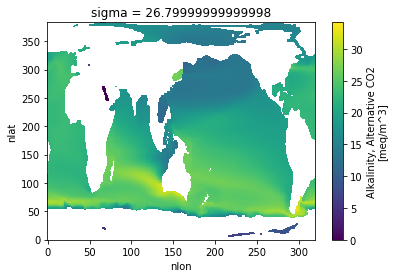

In [35]:
#diff_268 = ds_sigma_cesm.ALK.sel(sigma=26.8) - ds_sigma_cesm.ALK_ALT_CO2.sel(sigma=26.8)
diff_alk_268 = ds_sigma_cesm.ALK_ALT_CO2.isel(sigma=29) - ds_sigma_cesm.ALK.isel(sigma=29)
diff_alk_268.plot();

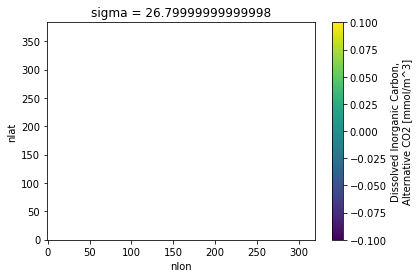

In [36]:
diff_dic_268 = ds_sigma_cesm2.DIC_ALT_CO2.isel(sigma=29) - ds_sigma_cesm2.DIC.isel(sigma=29)
diff_dic_268.plot();

In [29]:
ds_sigma_cesm.sigma[31]

<xarray.DataArray 'sigma' ()>
array(27.2)
Coordinates:
    sigma    float64 27.2

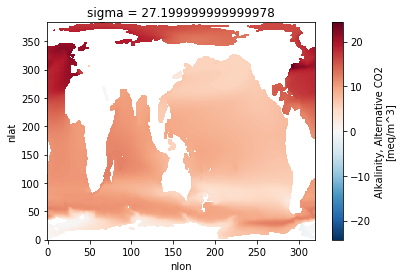

In [30]:
diff_alk_272 = ds_sigma_cesm.ALK_ALT_CO2.isel(sigma=31) - ds_sigma_cesm.ALK.isel(sigma=31)
diff_alk_272.plot();

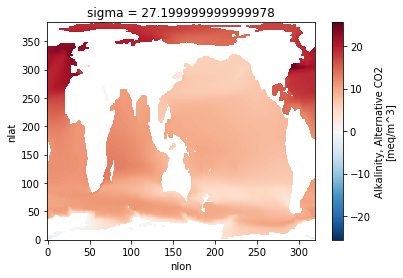

In [36]:
diff_272 = ds_sigma_cesm.ALK_ALT_CO2.isel(sigma=31) - ds_sigma_cesm.ALK.isel(sigma=31)
diff_272.plot();

In [31]:
ds_sigma_cesm.sigma[33]

<xarray.DataArray 'sigma' ()>
array(27.6)
Coordinates:
    sigma    float64 27.6

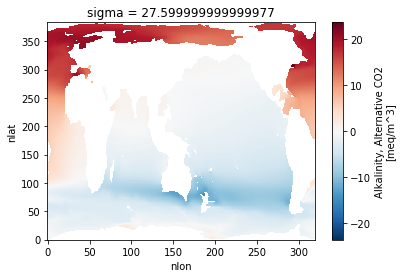

In [33]:
diff_alk_276 = ds_sigma_cesm.ALK_ALT_CO2.isel(sigma=33) - ds_sigma_cesm.ALK.isel(sigma=33)
diff_alk_276.plot()

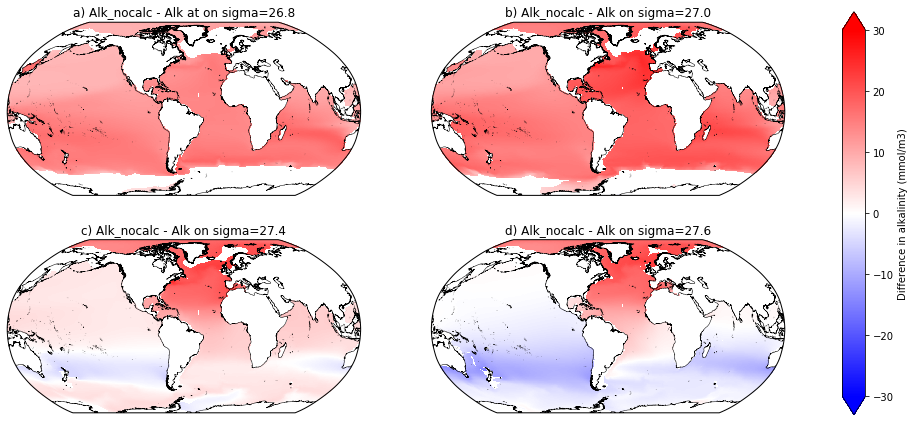

In [42]:
fig = plt.figure(figsize=(16,8))

######### Alk diff at surface layer
ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) Alk_nocalc - Alk at on sigma=26.8', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_268, cmap='bwr',vmin=-50, vmax=50,transform=ccrs.PlateCarree())


######### Alk diff at 200 m
ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) Alk_nocalc - Alk on sigma=27.0', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_270, cmap='bwr',vmin=-30, vmax=30,transform=ccrs.PlateCarree())

######### Alk diff at 482 m
ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) Alk_nocalc - Alk on sigma=27.4', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_274, cmap='bwr',vmin=-30, vmax=30,transform=ccrs.PlateCarree())

######### Alk diff at 787 m
ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('d) Alk_nocalc - Alk on sigma=27.6', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_276, cmap='bwr',vmin=-30, vmax=30,transform=ccrs.PlateCarree())



fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.16, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,label='Difference in alkalinity (mmol/m3)',extend='both')

In [43]:
def canvas_map_contour_overlay(lon,lat,z,
                               contour_specs,
                               units,
                               fig,
                               gridspec,
                               row,col):
    #-- make masked
    z = np.ma.masked_invalid(z)
    
    #-- make canvas
    ax = fig.add_subplot(gridspec[row,col],projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_global()

    #-- make filled contours
    cf = ax.contourf(lon,lat,z,
                     transform=ccrs.PlateCarree(),cmap='bwr',
                     **contour_specs)
    #-- rasterize
    zorder = 0
    for contour_level in cf.collections:
        contour_level.set_zorder(zorder)
        contour_level.set_rasterized(True)

    #-- add contour lines
    cs = ax.contour(lon,lat,z,
                    colors='k',
                    levels = contour_specs['levels'],
                    linewidths = 0.5,
                    transform=ccrs.PlateCarree(),
                    zorder=len(cf.collections)+10)
    fmt = '%r'
    #-- add contour labels
    lb = plt.clabel(cs, fontsize=8,
                   inline = True,
                   fmt=fmt)

    #-- add land mask
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='face',
                                            facecolor='black'))

#     #-- add colorbar
#     i = 0
#     while True:
#         i += 1
#         try:
#             gridspec[i]
#         except:
#             break
#     len_gs = i
#     if len_gs == 1:
#         shrink_factor = 0.75
#     else:
#         shrink_factor = 0.75

#     cb = fig.colorbar(cf,ax = ax,
#                       ticks = contour_specs['levels'],
#                       orientation = 'vertical',
#                       shrink = shrink_factor)
#     cb.ax.set_title(units)
#     cb.ax.tick_params(labelsize=9) 
    cb=0
    return {'ax':ax,'cf':cf,'cs':cs,'lb':lb,'cb':cb}

In [44]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [45]:
levels=np.arange(-36,37,2)
levels

array([-36, -34, -32, -30, -28, -26, -24, -22, -20, -18, -16, -14, -12,
       -10,  -8,  -6,  -4,  -2,   0,   2,   4,   6,   8,  10,  12,  14,
        16,  18,  20,  22,  24,  26,  28,  30,  32,  34,  36])

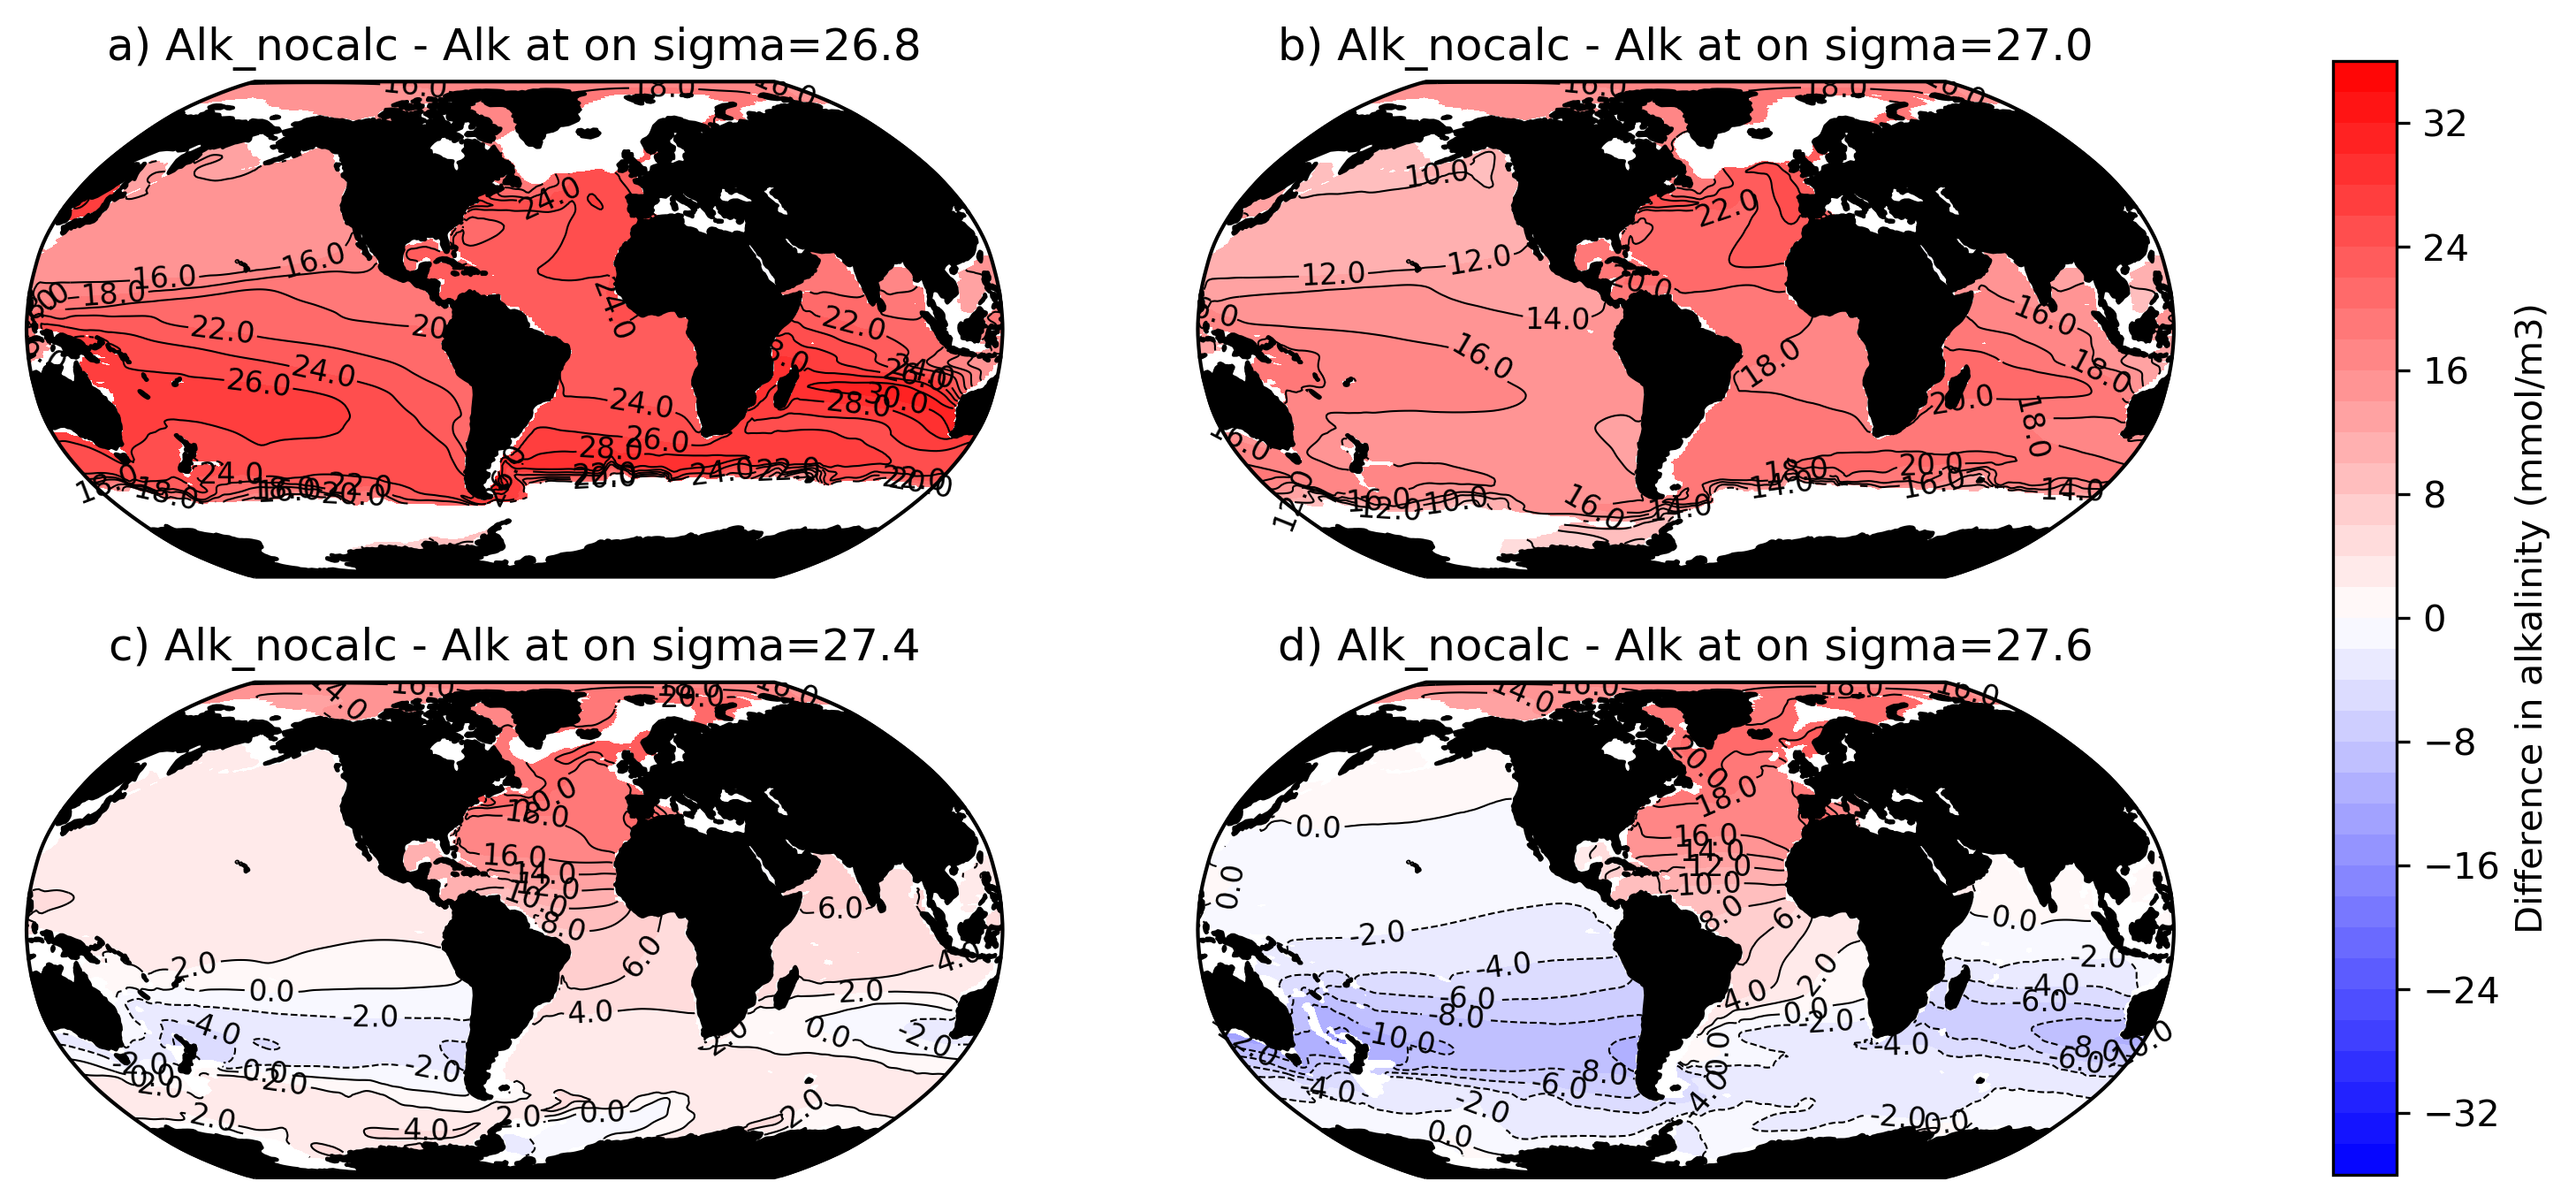

In [46]:


contour_specs = {'levels': levels}
fig=plt.figure(figsize=(12, 6),dpi=300)
gs = gridspec.GridSpec(2,2)
######### Alk diff atsigma=26.8

field = diff_268
lon,lat,field = adjust_pop_grid(lons,lats,field)

m = canvas_map_contour_overlay(lon,lat,field,
                                    contour_specs,
                                    units = units,
                                    fig=fig,
                                    gridspec=gs,
                                     row=0,col=0)
m['ax'].set_title('a) Alk_nocalc - Alk at on sigma=26.8', fontsize=12)

# ######### Alk diff at sigma=27.0
field = diff_270
lon,lat,field = adjust_pop_grid(lons,lats,field)

m = canvas_map_contour_overlay(lon,lat,field,
                                    contour_specs,
                                    units = units,
                                    fig=fig,
                                    gridspec=gs,
                                     row=0,col=1)
m['ax'].set_title('b) Alk_nocalc - Alk at on sigma=27.0', fontsize=12)

# ######### Alk diff at 482 m
field = diff_274
lon,lat,field = adjust_pop_grid(lons,lats,field)

m = canvas_map_contour_overlay(lon,lat,field,
                                    contour_specs,
                                    units = units,
                                    fig=fig,
                                    gridspec=gs,
                                     row=1,col=0)
m['ax'].set_title('c) Alk_nocalc - Alk at on sigma=27.4', fontsize=12)

# ######### Alk diff at 787 m
field = diff_276
lon,lat,field = adjust_pop_grid(lons,lats,field)

m = canvas_map_contour_overlay(lon,lat,field,
                                    contour_specs,
                                    units = units,
                                    fig=fig,
                                    gridspec=gs,
                                     row=1,col=1)
m['ax'].set_title('d) Alk_nocalc - Alk at on sigma=27.6', fontsize=12)


fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.16, 0.02, 0.7])
cbar = fig.colorbar(m['cf'],cax=cbar_ax,label='Difference in alkalinity (mmol/m3)')